In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy.fftpack import dctn,idctn
from scipy.fft import dctn, idctn
from scipy.signal import wiener
import time
import json

In [2]:
def read_image(path):
    """
    Reads an image from a given path and returns it in grayscale format.
    """
    #image = cv2.imread(path)  # Reads the image in BGR format
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Converts from BGR to RGB format
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return image


In [3]:
def extract_patches(image, B):
    """
    Partitions an image into a grid of partition_x x partition_y sub-images.
    If the image dimensions are not perfectly divisible, pads with black pixels.

    Returns:
    - A list of sub-images with shape (number_of_images, height, width)
    - A list of the top-left positions of each sub-image (y, x)
    - The size of the patch
    """
    height, width = image.shape

    # Calculate the number of partitions (sub-images) in x and y directions
    partition_y = -(-height // B)  # Number of sub-images in the vertical direction
    partition_x = -(-width // B)   # Number of sub-images in the horizontal direction
    patch_order = (partition_y, partition_x)
    # Calculate the required new dimensions
    padded_height = B * partition_y
    padded_width = B * partition_x

    # Create a new padded image filled with black pixels (padding)
    #print("B:",B, padded_height, padded_width)
    padded_image = np.zeros((padded_height, padded_width), dtype=image.dtype)
    padded_image[:height, :width] = image  # Copy the original image into the padded image

    # Initialize lists to store sub-images and their top-left positions
    patches = []
    top_left_positions = []

    # Split the padded image into sub-images and record the top-left position of each sub-image
    for y in range(partition_y):
        for x in range(partition_x):
            patch = padded_image[
                y * B: (y + 1) * B,
                x * B: (x + 1) * B
            ]
            patches.append(patch)
            top_left_positions.append((y * B, x * B))

    return np.array(patches), top_left_positions, patch_order

In [4]:
def reconstruct_from_patches(patches, image_shape):
    """
    Reassembles an image from a list of patches. (without position)
    The patches are assumed to be ordered in a row-major order (left to right, top to bottom).

    :param patches: numpy array of shape (N, patch_size, patch_size) containing N patches.
    :param image_shape: (height, width) of the original image.
    :return: the reconstructed image cropped to image_shape.
    """
    patch_size = patches.shape[1]  # Taille d'un patch

    # Déterminer le nombre de patches nécessaires pour couvrir l'image
    num_patches_y = (image_shape[0] + patch_size - 1) // patch_size  # Nombre de lignes de patches
    num_patches_x = (image_shape[1] + patch_size - 1) // patch_size  # Nombre de colonnes de patches

    # Création d'une image suffisamment grande pour contenir tous les patches
    reconstructed = np.zeros((num_patches_y * patch_size, num_patches_x * patch_size), dtype=patches.dtype)

    # Remplissage de l'image avec les patches dans l'ordre
    patch_idx = 0
    for i in range(0, num_patches_y * patch_size, patch_size):
        for j in range(0, num_patches_x * patch_size, patch_size):
            if patch_idx < patches.shape[0]:  # S'assurer qu'on ne dépasse pas le nombre de patches
                reconstructed[i:i+patch_size, j:j+patch_size] = patches[patch_idx]
                patch_idx += 1

    # Crop pour retourner à la taille originale
    return reconstructed[:image_shape[0], :image_shape[1]]

In [5]:
def display_image(image, title="Image"):
    """
    Display an image using matplotlib.
    :param image: an image
    :param title: the titles of the image
    :return: None
    """
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis('off')  # Disable axes
    plt.show()


In [6]:
def print_patches(patches,vertical_patch_order,horizontal_patch_order):
    """
    Displays patches with a small gap between them
    :param patches: 
    :param vertical_patch_order: vertical patch order
    :param horizontal_patch_order: horizontal patch order
    :return: 
    """
    cnt = 0
    for i in range(vertical_patch_order):
        for j in range(horizontal_patch_order):
            ax = plt.subplot(vertical_patch_order, horizontal_patch_order,cnt+1)
            plt.imshow(patches[i*horizontal_patch_order+j],cmap='gray',vmin=0, vmax=255)
            plt.xticks([])
            plt.yticks([])
            cnt+=1
    ax.set_aspect('equal')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

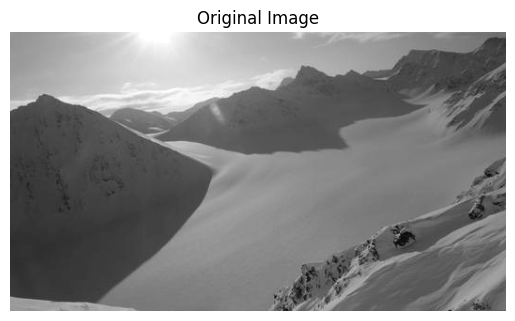

Original Image shape: (297, 528)


In [7]:
# Path to the image
image_path = "Images/2007041608_cam01p.jpg"
#image_path = "Images/lena.jpg"

# Read the image
image = read_image(image_path)
B = 15
# Partition the image
patches, _, patch_order = extract_patches(image, B)
display_image(image, "Original Image")
print("Original Image shape:", image.shape)


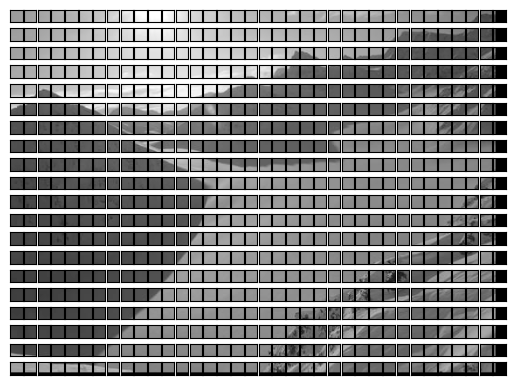

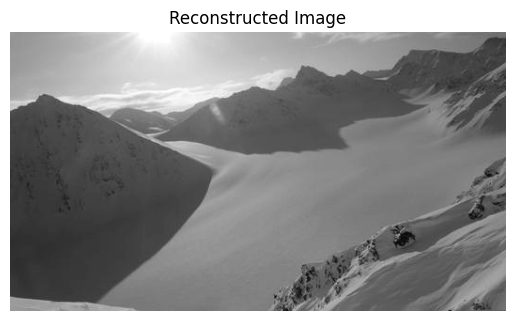

In [8]:
# Reassemble the image
print_patches(patches, patch_order[0], patch_order[1])
reconstructed_image = reconstruct_from_patches(patches, image.shape)
# Display the reassembled image
display_image(reconstructed_image, "Reconstructed Image")

**4- Vectorisation et vectorisation inverse**

In [9]:
def patches_to_vectors(patches):
    """ Convertit des patches en vecteurs. """
    return patches.reshape(patches.shape[0], -1)
def vectors_to_patches(vectors, patch_size=8):
    """ Convertit des vecteurs en patches. """
    return vectors.reshape(-1, patch_size, patch_size)

## 5- Matrice de mesure

In [10]:
from random import *
seed(42)
# M = 0.1 B^2
# M taille de y, M<<N
# N taille de x
def phi(M, N):
    """
    :param M: Taille M
    :paran N: Taille N
    """
    variance = 1 / M
    return np.random.normal(0, np.sqrt(variance), (M, N))

**Algorithme (Block Compressed Sensing with Smoothed Projected Landweber and Discrete Cosine Transform) BCS-SPL-DCT**

In [11]:
def threshold(X, lamb=6):
    """
    Apply hard thresholding to the input data X.

    :param X: Input data (a patch)
    :param lamb: Threshold scaling parameter.
    :return: array-like: Data after applying the hard threshold.
    """
    N1, N2 = np.shape(X)
    threshold_value = lamb * (np.median(np.abs(X)) / 0.6745) * np.sqrt(2 * np.log(N1 * N2))
    X_thresholded = np.where(np.abs(X) > threshold_value, X, 0)

    return X_thresholded

In [12]:
def dct_2d(patch):
    """
    Perform a 2D Discrete Cosine Transform (DCT) on a patch using dctn.
    :param patch (ndarray): Input 2D array (e.g., image patch).
    :return: ndarray: DCT-transformed 2D array.
    """
    return dctn(patch)  # Directly applies 2D DCT

def idct_2d(patch):
    """
    Perform an inverse 2D Discrete Cosine Transform (IDCT) on a patch using idctn.
    :param patch (ndarray): Input 2D array (DCT-transformed patch).
    :return: ndarray: Reconstructed 2D array after applying IDCT.
    """
    return idctn(patch)  # Directly applies 2D IDCT

In [13]:
def update_vectors(Phi, Phi_T, y_vectors, x_vectors, alpha=0.1): # Descente du gradient
    """
    Update the vectors during the BCS-SPL reconstruction process.

    Parameters:
        Phi (ndarray): Measurement matrix (M x N).
        Phi_T (ndarray): Transpose of the measurement matrix (N x M).
        y_vectors (ndarray): Compressed measurements (M x number of patches).
        x_vectors (ndarray): Current estimate of the vectors (N x number of patches).
        alpha (float): Step size parameter for the update (default is 0.1).

    Returns:
        ndarray: Updated x_vectors (N x number of patches).
    """
    phi_x_vectors = Phi @ x_vectors.T
    corrections = Phi_T @ (y_vectors.T - phi_x_vectors)
    updated_vectors = x_vectors.T + alpha * corrections  # Ajout d'un facteur de relaxation
    return np.clip(updated_vectors.T, -255, 255)  # Évite les valeurs extrêmes
def BCS_SPL(X_rec, Phi, y_vectors, Phi_T, image_shape, patch_size=8, lamb=12, alpha=0.1):
    """
    Perform a single iteration of image reconstruction using BCS-SPL (Basis Pursuit Denoising with Sparse Patch Learning).

    Parameters:
        X_rec (ndarray): The initial reconstruction of the image.
        Phi (ndarray): The measurement matrix (M x N).
        y_vectors (ndarray): The compressed measurements (M x number of patches).
        Phi_T (ndarray): The transpose of the measurement matrix (N x M).
        image_shape (tuple): Shape of the original image (height, width).
        patch_size (int): Size of the patches (default is 8).
        lamb (float): Threshold for sparsity (regularization parameter).
        alpha (float): Step size for updating the vectors.

    Returns:
        ndarray: The updated reconstructed image after one iteration.
    """
    # Étape 1 : Optimisation sans contrainte (descente du gradient)
    x_patches, _, _ = extract_patches(X_rec, patch_size)
    x_vectors = patches_to_vectors(x_patches)
    new_x_vectors = update_vectors(Phi, Phi_T, y_vectors, x_vectors, alpha=alpha)
    new_X = reconstruct_from_patches(vectors_to_patches(new_x_vectors, patch_size), image_shape)
    # Étape 2a : Transformation en domaine parcimonieux (DCT)
    new_X_DCT = dct_2d(new_X)

    # Étape 2b : Seuillage fort pour améliorer la parcimonie
    new_X_DCT_thresholded = threshold(new_X_DCT, lamb)

    # Étape 2c : Reconstruction inverse en appliquant la DCT inverse
    X_rec = idct_2d(new_X_DCT_thresholded)

    # Étape 2d : Mise à jour après seuillage pour améliorer la solution
    new_x_patches, _, _ = extract_patches(X_rec, patch_size)
    new_x_vectors = patches_to_vectors(new_x_patches)
    new_x_vectors = update_vectors(Phi, Phi_T, y_vectors, new_x_vectors, alpha=alpha)
    X_rec = reconstruct_from_patches(vectors_to_patches(new_x_vectors, patch_size), image_shape)

    return X_rec
def BCS_SPL_iterative(img, Phi, y_vectors, patch_size=8, lamb=12, max_iters=100, epsilon=1e-4, alpha=0.1):
    """
    Iterative reconstruction using BCS-SPL with stabilization factor and clipping.

    :param img: The input degraded image to be reconstructed.
    :param Phi: The measurement matrix used for compressed sensing.
    :param y_vectors: The measured signal vectors obtained from Phi.
    :param patch_size: The size of the patches extracted from the image.
    :param lamb: Initial thresholding parameter for sparsity.
    :param max_iters: Maximum number of iterations.
    :param epsilon: Tolerance for stopping criterion based on error improvement.
    :param alpha: Relaxation factor for stability in the iterative updates.
    :return: The reconstructed image and the final error value.
    """
    Phi_T = Phi.T
    prev_error = float('inf')
    X_rec = wiener(img, (3, 3))  # PAS DANS LA LOOP CAR SINON LA QUALITE DE L IMAGE DIMINUE
    image_shape = img.shape
    for i in range(max_iters):

        X_rec = BCS_SPL(X_rec, Phi, y_vectors, Phi_T, image_shape, patch_size=patch_size, lamb=lamb, alpha=alpha)
        lamb *= 0.9  # Réduction progressive du seuil, similaire au learning rate scheduler

        # Calcul de l'erreur et critère d'arrêt
        error = np.linalg.norm(X_rec - img) / np.linalg.norm(img)
        #print(f"Itération {i+1} - Erreur: {error:.6f}")

        if abs(prev_error - error) < epsilon:
            print("Arrêt : l'amélioration est négligeable.")
            break

        prev_error = error
    #print(f"Itération {i+1} - Erreur: {error:.6f}")
    return X_rec, error

In [14]:
def calculate_psnr(original_image, reconstructed_image):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images.
    
    Parameters:
        original_image (ndarray): The original image (height, width).
        reconstructed_image (ndarray): The reconstructed image (height, width).
        
    Returns:
        float: The PSNR value in decibels (dB).
    """
    # Faccultatif, être sur d'avoir le même type
    original_image = original_image.astype(np.float32)
    reconstructed_image = reconstructed_image.astype(np.float32)
    
    # Calculer l'erreur quadratique moyenne (MSE)
    mse = np.mean((original_image - reconstructed_image) ** 2)
    
    # Si MSE est égal à zéro (images identiques), le PSNR est infini
    if mse == 0:
        return float('inf')
    
    # Trouver la valeur maximale des pixels (255 pour des images en 8 bits)
    max_pixel = 255.0
    
    # Calculer le PSNR
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    
    return psnr


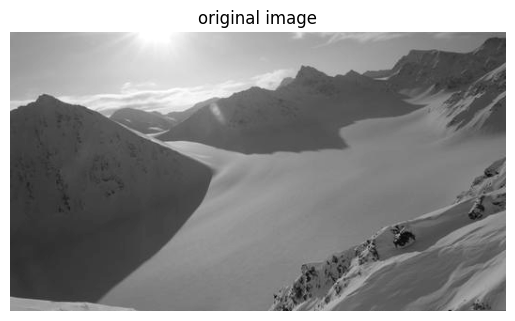

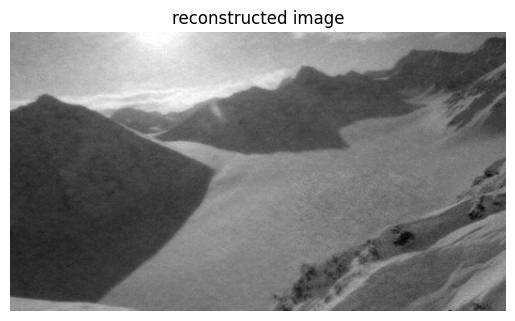

img: (297, 528)
reconstructed_img: (297, 528)
Error: 0.041993979563900885
PSNR: 33.007276449769904


In [18]:
patch_size = 150
np.random.seed(1)
patches_order = int(np.sqrt(patch_size * patch_size))
M = int(np.floor(patches_order ** 2 * 0.3))
Phi = phi(M, patches_order ** 2)  #Matrix of measure
image_path = "Images/2007041608_cam01p.jpg"
img = read_image(image_path)

# Compression
x_patches, _, _ = extract_patches(img, patch_size)
x_vectors = patches_to_vectors(x_patches)
y_vectors = (Phi @ x_vectors.T).T

# Reconstruction itérative
reconstructed_img, error = BCS_SPL_iterative(img, Phi, y_vectors, patch_size, lamb=12, max_iters=100, epsilon=1e-12)
display_image(img, "original image")
display_image(reconstructed_img, "reconstructed image")
print("img:",img.shape)
print("reconstructed_img:", reconstructed_img.shape)
print("Error:", error)
print("PSNR:", calculate_psnr(img, reconstructed_img))

In [46]:
def plot_results(patch_sizes, error_results, psnr_results, time_results):
    """
    Plots the results of error, PSNR, and execution time against patch sizes.
    :param patch_sizes: List of patch sizes.
    :param error_results: Dictionary where keys are (measure_ratio, lambda) tuples,
                          and values are lists of corresponding errors.
    :param psnr_results: Dictionary where keys are (measure_ratio, lambda) tuples,
                         and values are lists of corresponding PSNR values.
    :param time_results: Dictionary where keys are (measure_ratio, lambda) tuples,
                         and values are lists of corresponding execution times.
    :return: None
    """
    colors = ['blue', 'red', 'green', 'purple', 'orange']
    marker_styles = ['o', 's', '^', 'd', 'x', '*', '+', 'v', '>', '<', 'p', '|']
    
    # Affichage des erreurs
    plt.figure(figsize=(10, 6))
    for idx, ((measure_ratio, lamb), errors) in enumerate(error_results.items()):
        color_idx = idx % len(colors)
        marker_idx = (idx // len(colors)) % len(marker_styles)  # Change marker after all colors are used
        label = f"Ratio={measure_ratio}, Lambda={lamb}"
        plt.scatter(patch_sizes, errors, marker=marker_styles[marker_idx],
                    color=colors[color_idx], linestyle='-', label=label)
    plt.xlabel("Patch Size")
    plt.ylabel("Average Error")
    plt.title("Error vs Patch Size for Different Measure Ratios and Lambda Values")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Affichage des PSNR
    plt.figure(figsize=(10, 6))
    for idx, ((measure_ratio, lamb), psnrs) in enumerate(psnr_results.items()):
        color_idx = idx % len(colors)
        marker_idx = (idx // len(colors)) % len(marker_styles)  # Change marker after all colors are used
        label = f"Ratio={measure_ratio}, Lambda={lamb}"
        plt.scatter(patch_sizes, psnrs, marker=marker_styles[marker_idx],
                    color=colors[color_idx], linestyle='-', label=label)
    plt.xlabel("Patch Size")
    plt.ylabel("Average PSNR (dB)")
    plt.title("PSNR vs Patch Size for Different Measure Ratios and Lambda Values")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Affichage des temps d'exécution
    plt.figure(figsize=(10, 6))
    for idx, ((measure_ratio, lamb), times) in enumerate(time_results.items()):
        color_idx = idx % len(colors)
        marker_idx = (idx // len(colors)) % len(marker_styles)  # Change marker after all colors are used
        label = f"Ratio={measure_ratio}, Lambda={lamb}"
        plt.scatter(patch_sizes, times, marker=marker_styles[marker_idx],
                    color=colors[color_idx], linestyle='-', label=label)
    plt.xlabel("Patch Size")
    plt.ylabel("Average Execution Time (seconds)")
    plt.title("Execution Time vs Patch Size for Different Measure Ratios and Lambda Values")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def launch_test(patch_size=33, measure_ratio=0.5, lamb=12):
    """
    Performs a test of compressive sensing-based image reconstruction.
    :param patch_size: Size of the patches extracted from the image (default: 33).
    :param measure_ratio: Ratio of measurements used for compression (default: 0.5).
    :param lamb: Regularization parameter for the reconstruction algorithm (default: 12).
    :return: The reconstruction error and PSNR (Peak Signal-to-Noise Ratio).
    """
    patches_order = int(np.sqrt(patch_size * patch_size))
    M = int(np.floor(patches_order ** 2 * measure_ratio))  # Ratio appliqué sur M
    Phi = phi(M, patches_order ** 2)  # Matrice de mesure

    image_path = "Images/2007041608_cam01p.jpg"
    img = read_image(image_path)

    # Compression
    x_patches, _, _ = extract_patches(img, patch_size)
    x_vectors = patches_to_vectors(x_patches)
    y_vectors = (Phi @ x_vectors.T).T

    # Reconstruction itérative
    reconstructed_img, error = BCS_SPL_iterative(img, Phi, y_vectors, patch_size, lamb=lamb, max_iters=100, epsilon=1e-10)
    psnr = calculate_psnr(img, reconstructed_img)
    return error, psnr
def launch_test(img, patch_size=33, measure_ratio=0.5, lamb=12):
    patches_order = int(np.sqrt(patch_size * patch_size))
    M = int(np.floor(patches_order ** 2 * measure_ratio))  # Ratio appliqué sur M
    Phi = phi(M, patches_order ** 2)  # Matrice de mesure

    # Compression
    x_patches, _, _ = extract_patches(img, patch_size)
    x_vectors = patches_to_vectors(x_patches)
    y_vectors = (Phi @ x_vectors.T).T

    # Reconstruction itérative
    reconstructed_img, error = BCS_SPL_iterative(img, Phi, y_vectors, patch_size, lamb=lamb, max_iters=100, epsilon=1e-10)
    psnr = calculate_psnr(img, reconstructed_img)
    return error, psnr

In [ ]:
np.random.seed(1)
# Paramètres de test
patch_sizes = [k for k in range(10, 151, 10)]
measure_ratios = [0.2, 0.3, 0.5, 0.7]
lambda_values = [5, 10, 12, 15, 20]
num_repeats = 3  # Nombre de répétitions par configuration

# Image chargé pour éviter d'avoir à la recharger à chaque itération
image_path = "Images/2007041608_cam01p.jpg"
img = read_image(image_path)

# Stocker les résultats
error_results = {}
psnr_results = {}
time_results = {}

# Test pour toutes les combinaisons de paramètres
for measure_ratio in measure_ratios:
    for lamb in lambda_values:
        errors = []
        psnrs = []
        times = []  # Stocker les temps d'exécution
        for patch_size in patch_sizes:
            error_values = []
            psnr_values = []
            time_values = []  # Stocker les temps d'exécution pour chaque répétition

            for _ in range(num_repeats):
                start_time = time.time()  # Début du chrono
                error, psnr = launch_test(img, patch_size, measure_ratio, lamb)
                end_time = time.time()  # Fin du chrono

                error_values.append(error)
                psnr_values.append(psnr)
                time_values.append(end_time - start_time)  # Calcul du temps écoulé

            mean_error = np.mean(error_values)
            mean_psnr = np.mean(psnr_values)
            mean_time = np.mean(time_values)

            errors.append(mean_error)
            psnrs.append(mean_psnr)
            times.append(mean_time)

        # Stocker les erreurs, PSNR et le temps moyen pour cette configuration
        error_results[(measure_ratio, lamb)] = errors
        psnr_results[(measure_ratio, lamb)] = psnrs
        time_results[(measure_ratio, lamb)] = times
# Devrait prendre moins de 2h avec 16G et 32c

Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.
Arrêt : l'amélioration est négligeable.


In [22]:
import json

# Créer une structure imbriquée : dict de dict de dict
results = {}

for k, error in error_results.items():
    ratio_lambda_key = f"Ratio={k[0]}_Lambda={k[1]}"
    results[ratio_lambda_key] = {
        "error": error,
        "psnr": psnr_results[k],
        "time": time_results[k]
    }

# Sauvegarde dans un fichier JSON
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Les résultats ont été sauvegardés dans 'results.json'")


Les résultats ont été sauvegardés dans 'results.json'


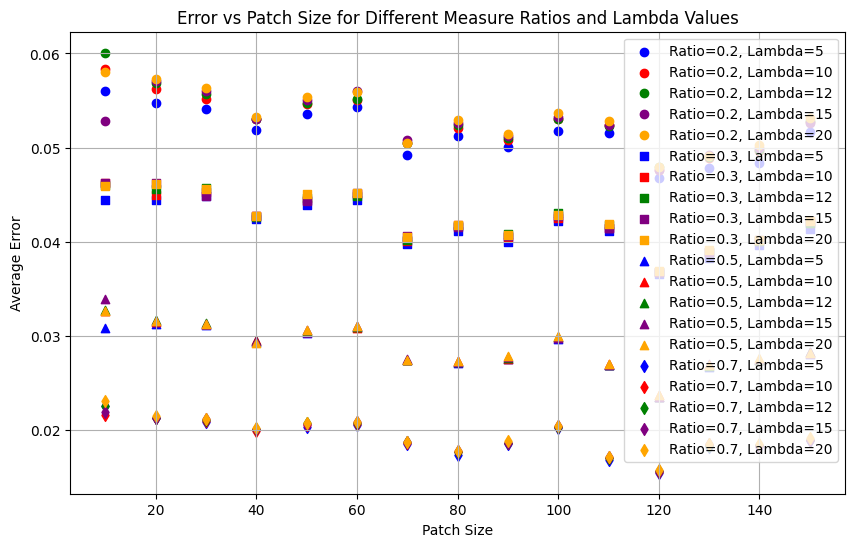

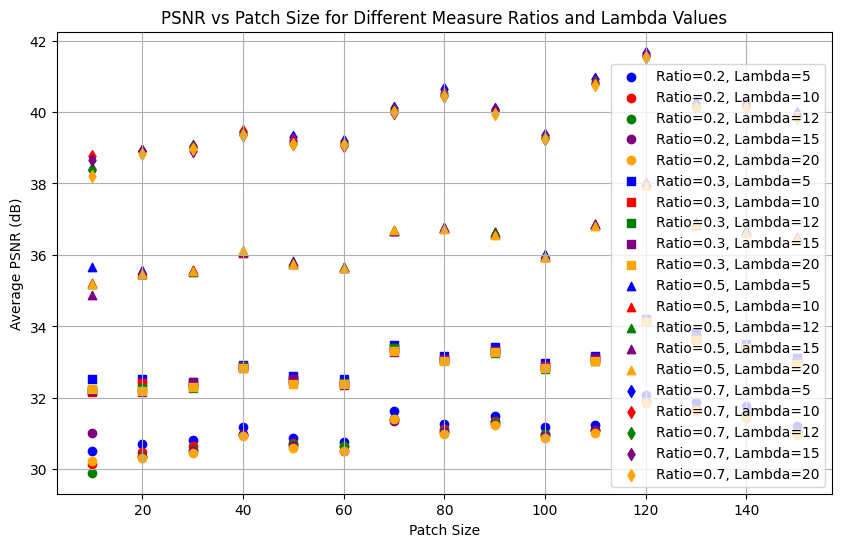

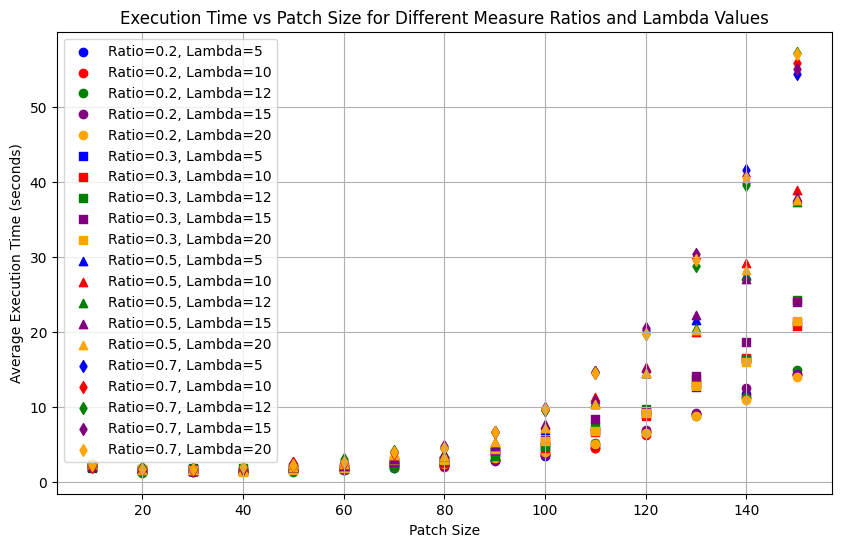

In [47]:
import json
# Charger les résultats depuis le fichier JSON
with open("results.json", "r") as f:
    loaded_results = json.load(f)
patch_sizes = [k for k in range(10, 151, 10)]
# Reconstruction des dictionnaires
error_results = {}
psnr_results = {}
time_results = {}

for key, values in loaded_results.items():
    # Extraire ratio et lambda depuis la clé "Ratio=0.3_Lambda=5"
    parts = key.replace("Ratio=", "").replace("Lambda=", "").split("_")
    measure_ratio = float(parts[0])
    lamb = int(parts[1])

    error_results[(measure_ratio, lamb)] = values["error"]
    psnr_results[(measure_ratio, lamb)] = values["psnr"]
    time_results[(measure_ratio, lamb)] = values["time"]

# Utilisation de la fonction d'affichage
plot_results(patch_sizes, error_results, psnr_results, time_results)